In [3]:
# Standard Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add additional imports under here
import numpy as np
from pathlib import Path
import re
import stopwordsiso as stopwords
from deep_translator import GoogleTranslator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator
import spacy
from collections import Counter
import math
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
from google import genai
import os
from dotenv import load_dotenv
import json
from sklearn.preprocessing import StandardScaler

c:\Users\116su\source\repos\Assignment_3_Code\venv\Lib\site-packages\stopwordsiso\_core.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\116su\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\116su\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
#loading
df = pd.read_excel("lexicon_6000 words.xlsx")

#keep a copy of the original columns
original_Cols = df.columns.tolist()
print(original_Cols)

df.head()

['CILUBA', 'French', 'Score', 'Sentiment', 'Nature']


,CILUBA,French,Score,Sentiment,Nature
0,Akaja,Arrange,1.0,Positif,Verbe
1,Akajilula,Rearrange,1.0,Positif,Verbe
2,Akula,Parle,2.0,Positif,Verbe
3,Akulula,Reparle,2.0,Positif,Verbe
4,Aluja,Remet,3.0,Positif,Verbe


In [3]:
dup_Count = df.duplicated().sum()
print(dup_Count)

if dup_Count > 0:
    print("dataset size:", len(df)) 
    df = df.drop_duplicates()
    print("new dataset size:", len(df))

#taking away any duplication/ spacing errors
col_Strings = df.select_dtypes(include=['object']).columns
for col in col_Strings:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].str.replace(r'\s+','', regex=True)

317
dataset size: 6963
new dataset size: 6646


In [4]:
new_Languages = ["English", "Zulu", "Afrikaans", "Sepedi", "Xhosa", "Shona"]

for lang in new_Languages:
    if lang not in df.columns:
        df[lang] = np.nan

df.head()

,CILUBA,French,Score,Sentiment,Nature,English,Zulu,Afrikaans,Sepedi,Xhosa,Shona
0,Akaja,Arrange,1.0,Positif,Verbe,NaN,NaN,NaN,NaN,NaN,NaN
1,Akajilula,Rearrange,1.0,Positif,Verbe,NaN,NaN,NaN,NaN,NaN,NaN
2,Akula,Parle,2.0,Positif,Verbe,NaN,NaN,NaN,NaN,NaN,NaN
3,Akulula,Reparle,2.0,Positif,Verbe,NaN,NaN,NaN,NaN,NaN,NaN
4,Aluja,Remet,3.0,Positif,Verbe,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
from deep_translator import GoogleTranslator

def translate_French_To_English(text):
    if pd.isna(text) or text.strip=="":
        return np.man
    try:
        return GoogleTranslator(source='fr', target='en').translate(text)
    except Exception:
        return np.nan

def translate_English_To_Language(text, language_Code):
    if pd.isna(text) or text.strip()=="":
        return np.man
    try:
        return GoogleTranslator(source="en", target=language_Code).translate(text)
    except Exception:
        return np.nan

In [ ]:
from tqdm import tqdm

tqdm.pandas()

df["English"] = df["French"].progress_apply(translate_French_To_English)

In [ ]:
print("Errors occured:", df["English"].isna().sum())
print("Unique English words:", df["English"].nunique(dropna=True))

Errors occured: 0
Unique English words: 3864


In [ ]:
language_Code = {"Zulu":"zu", "Afrikaans":"af", "Sepedi":"nso", "Xhosa":"xh", "Shona":"sn"}

for lang, code in language_Code.items():
    df[lang] = df["English"].progress_apply(lambda x: translate_English_To_Language(x, code))

100%|████████████████████████████████████████████████████████████████████████████| 6632/6632 [2:19:04<00:00,  1.26s/it]


In [ ]:
df.head(20)

,CILUBA,French,Score,Sentiment,Nature,English,Zulu,Afrikaans,Sepedi,Xhosa,Shona
0,Akaja,Arrange,1.0,Positif,Verbe,Arrange,Hlela,Reël,Beakanya,Cwangcisa,Ronga
1,Akajilula,Rearrange,1.0,Positif,Verbe,Rear range,Ibanga langemuva,Grootafstand,Range ya ka morao .,Uluhlu lwangasemva,Kumashure
2,Akula,Parle,2.0,Positif,Verbe,Speak,Khuluma,Praat,Bolela,Thetha,Taura
3,Akulula,Reparle,2.0,Positif,Verbe,Speak again,Khuluma futhi,Praat weer,Bolela gape .,Thetha kwakhona,Taura zvakare
4,Aluja,Remet,3.0,Positif,Verbe,Hands over,Izandla ngaphezulu,Hande om,diatla godimo ga .,Izandla ngaphezulu,Maoko pamusoro
5,Amba,Dis,3.0,Positif,Verbe,Say,Khuluma,Sê,Bolela,Yithi,Taura
6,Ambakaja,Supperpose,3.0,Positif,Verbe,Suppose,Cabanga,Veronderstel,Nagana,Cinga,Ngatitii
7,Ambula,Ramasse,4.0,Positif,Verbe,Pick up,Phakamisa,Optel,Topa,Phakamisa,Nhonga
8,Ambuluja,Depeche,4.0,Positif,Verbe,Depeche,I-depeche,Depeche,Depeche .,I-dope,Zvinorevache
9,Ambulula,Repete,9.0,Positif,Verbe,Repeated,-Phindaphiwe,Herhaal,pheta-pheta .,Iphindaphindwe,Kudzokororwa


In [ ]:
#missing translations (NaN)
for lang in ["Zulu","Afrikaans","Sepedi","Xhosa","Shona"]:
    print(f"{lang}: missing {df[lang].isna().sum()}")

# unique counter
df[["English","Zulu","Afrikaans","Sepedi","Xhosa","Shona"]].nunique()

Zulu: missing 1
Afrikaans: missing 0
Sepedi: missing 0
Xhosa: missing 1
Shona: missing 1


English      3864
Zulu         3513
Afrikaans    3647
Sepedi       3376
Xhosa        3367
Shona        3156
dtype: int64

In [4]:
df_lexicon = pd.read_excel('./lexicon_dataset/expanded_lexicon.xlsx')

sentiment_map = {
    # French / variants meaning Positive
    "Positive": "positive",
    "Positf": "positive",
    "Positidf": "positive",
    "Positiveouneutre": "positive",
    "Positiveetnaturelle": "positive",
    "Trespositive": "positive",
    "Trèspositive": "positive",

    # French / variants meaning Negative
    "Negative": "negative",
    "Négative": "negative",
    "Tresnegative": "negative",
    "Trèsnegative": "negative",

    # Neutral / misspelled variants
    "Neutre": "neutral",
    "Neutrre": "neutral",
    "Neuitre": "neutral",

    # Ambiguous terms
    "Ambivalent": "neutral",   # interpret ambivalent as neutral
}

df_lexicon['Sentiment'] = df_lexicon['Sentiment'].map(sentiment_map)
df_lexicon.to_excel('./lexicon_dataset/expanded_lexicon_cleaned.xlsx', index=False)
print(df_lexicon["Sentiment"].value_counts())

Sentiment
positive    4361
neutral     1121
negative    1116
Name: count, dtype: int64


In [ ]:
def tokenize_text(text):
    text = text.translate(str.maketrans('', '', '()[]{}1234567890.?!')).lower().split('\t')
    return text

if stopwords.has_lang("zu"):
    zulu_stopwords = stopwords.stopwords("zu") # Used to filter out common words
else:
    print("No stopwords found for Zulu")
    
if stopwords.has_lang("en"):
    english_stopwords = stopwords.stopwords("en") # Used to filter out common words
else:
    print("No stopwords found for English")

df_lexicon_clean = pd.read_excel('./lexicon_dataset/expanded_lexicon_cleaned.xlsx')
# df_lexicon_clean = df_lexicon_clean.drop('Unnamed: 0', axis=1)
print('Pre cleaning dataset length: ', len(df_lexicon_clean))

for col in df_lexicon_clean.columns:
    if col != 'Score':
        df_lexicon_clean[col] = df_lexicon_clean[col].str.lower()

lang_key = {
    "English": "en",
    "Zulu": "zu",
    "Afrikaans": "af",
    "Sepedi": "nso",
    "Xhosa": "xh",
    "Shona": "sn"
}

async def retokenize_text(text, index):
    newtext = ''
    tokens = text.split(' ')
    tokens = [token if token not in english_stopwords else '' for token in tokens]
    for token in tokens:
       newtext += token
    if newtext == '':
        return None
    if newtext != text:
        await retranslator(index)
    return newtext

translator = Translator()
async def retranslator(text):
    for col in ["French","Zulu","Afrikaans","Sepedi","Xhosa","Shona"]:
        if text is None or df_lexicon_clean.at[index, col] is None:
            detect = await translator.detect(df_lexicon_clean.at[index, 'English'])
            if detect.lang != 'en':
                try:
                    translated = translator.translate(df_lexicon_clean.at[index, 'English'], src=detect.lang, dest=lang_key[col])
                    df_lexicon_clean.at[index, col] = translated.text
                    print(f'translated {df_lexicon_clean.at[index, 'English']} to {translated.text}')
                except:
                    print(f'could not translate {df_lexicon_clean.at[index, 'English']} to {col}')
                    continue

# Translate null translated columns
for text in df_lexicon_clean['English']:
    await retranslator(text)

# Dropping stop words of zulu text
for index, row in df_lexicon_clean.iterrows():
    if row['Zulu'] in zulu_stopwords:
        df_lexicon_clean = df_lexicon_clean.drop(index)
        continue
    
    df_lexicon_clean.at[index, 'English'] = await retokenize_text(row['English'], index)
    if row['English'] in english_stopwords:
        df_lexicon_clean = df_lexicon_clean.drop(index)

print('Pre nan dropped: ', df_lexicon_clean[['English', 'French']].isnull().value_counts())
df_lexicon_clean = df_lexicon_clean.dropna(subset=['French', 'English'])
print('Post nan dropped: ', df_lexicon_clean[['English', 'French']].isnull().value_counts())

scaler = StandardScaler()
df_lexicon_clean['Score'] = np.ceil(scaler.fit_transform(df_lexicon_clean[['Score']]).flatten())

newSentiments = []
for index, row in df_lexicon_clean.iterrows():   
    if row['Score'] > 0.5:
        newSentiments.append('positive')
    elif row['Score'] < -0.5:
        newSentiments.append('negative')
    else:
        newSentiments.append('neutral')

df_lexicon_clean['Sentiment'] = newSentiments
df_lexicon_clean = df_lexicon_clean.drop_duplicates()
print('Post cleaning dataset length: ', len(df_lexicon_clean))
print(df_lexicon_clean['Sentiment'].value_counts())
df_lexicon_clean.to_excel('./lexicon_dataset/expanded_lexicon_cleaned.xlsx')

In [175]:
# Lemmating and re-runing pos taging in using french words to reduce ambiguity 
lemmatizer = FrenchLefffLemmatizer()

print('french duplicates: ', df_lexicon_clean['French'].duplicated().value_counts())
print('lemmatizing...')
for index, row in df_lexicon_clean.iterrows():
    if row['French'] is not None:
        lemma = lemmatizer.lemmatize(row['French'])
        if row['French'] != lemma:
            await retranslator(index)

for index, row in df_lexicon_clean.iterrows():
    if row['English'] in zulu_stopwords:
        df_lexicon_clean = df_lexicon_clean.drop(index)

df_lexicon_clean = df_lexicon_clean.dropna(axis=0, subset=["English","Zulu","Afrikaans","Sepedi","Xhosa","Shona",'French'])
df_lexicon_clean = df_lexicon_clean.drop_duplicates()
print('post lemmatizing french duplicates: ', df_lexicon_clean['French'].duplicated().value_counts())

french duplicates:  French
False    3288
True     2027
Name: count, dtype: int64
lemmatizing...
post lemmatizing french duplicates:  French
False    3285
True     2027
Name: count, dtype: int64


In [176]:
# Extracting different text features from the corpus extracted from SADII of news articles in isiZulu
file = open('SADII-Ext.Caps.POS.2024-01-31.zu.txt', 'r', encoding='utf-8')
lines = file.read()
lines = lines.splitlines()
file.close()
    
df_corpus = pd.DataFrame(lines, columns=['isiZulu'])
df_corpus['isiZulu'] = df_corpus['isiZulu'].str.strip()

print("Total text samples from corpus: ", len(df_corpus))
print(df_corpus.head())

Total text samples from corpus:  4640
            isiZulu
0          <LINE 1>
1  Abacwaningi\tN02
2          bathi\tV
3      ukujezisa\tV
4   ngokushaya\tADV


In [177]:
# Cleaning and Tokenization
df_corpus_text = pd.DataFrame(columns=['isiZulu'])
words = []
# Reverse engineering the text samples based on <line> tags
text = ''
for corpus_text in df_corpus['isiZulu']:
    if '<line' in corpus_text.lower():
        if text:
            text = text.strip().replace('"', '')
            df_corpus_text.loc[len(df_corpus_text)] = text
            
        text = ''
        continue
    
    tokens = tokenize_text(corpus_text)
    text += tokens[0] + ' '
    words.append({'isiZulu': tokens[0], 'POS': tokens[1].upper()})

df_corpus = pd.DataFrame(words, columns=['isiZulu', 'POS'])
print("Total text samples: ", len(df_corpus_text))
print(df_corpus_text.head())

Total text samples:  465
                                             isiZulu
0  abacwaningi bathi ukujezisa ngokushaya noma ng...
1  abafundi abasebancane kakhulu bona bangakuthok...
2                                       abangaphoqwa
3  abantu abaningi bayaluthokozela lolu hlelo kwa...
4  abantu abasha bakhala ngemfundo yamahhala kany...


In [178]:
# POS Mapping
tags = {
    "PUNC": "Punctuation",
    "ABBR": "Abbreviation",
    "ADJ": "Adjective",
    "ADV": "Adverb",
    "ASP": "Aspectual marker",
    "AUX": "Auxiliary stem",
    "CDEM": "Class-indicating demonstrative",
    "CN": "Class-indicating nominal prefix",
    "CO": "Class-indicating object concord",
    "CONJ": "Conjunction",
    "COP": "Copulative",
    "CS": "Class-indicating subject concord",
    "FOR": "Foreign",
    "IDEO": "Ideophone",
    "INT": "Interjection",
    "INTER": "Question",
    "MNEG": "Negative morpheme",
    "N": "Noun",
    "NPP": "Noun",
    "NUM": "Numerative",
    "PART": "Particle",
    "POSS": "Possessive",
    "PROEMP": "Emphatic pronoun",
    "PROQUANT": "Quantitative pronoun",
    "REL": "Relative",
    "TENS": "Tense marker",
    "V": "Verbal",
    "VAUX": "Auxiliary verb"
}

print('initial length: ', len(df_corpus))
df_corpus['POS'] = df_corpus['POS'].map(tags)
df_corpus = df_corpus[df_corpus['POS'] != 'Punctuation']
print('final length: ', len(df_corpus))
print(df_corpus.head())

initial length:  4174
final length:  3634
       isiZulu          POS
0  abacwaningi         Noun
1        bathi       Verbal
2    ukujezisa       Verbal
3   ngokushaya       Adverb
4         noma  Conjunction


In [179]:
english_text = []
sentiment_result = []
analyzer = SentimentIntensityAnalyzer()

print('Corpus translation in progress')
for sentence in df_corpus_text['isiZulu']:
    translated_text = GoogleTranslator(source='auto', target='en').translate(sentence)
    sentiment_dict = analyzer.polarity_scores(translated_text)
    
    english_text.append(translated_text)
    if sentiment_dict['compound'] >= 0.05:
        sentiment_result.append('Positive')     
    elif sentiment_dict['compound'] <= - 0.05:
        sentiment_result.append('Negative')   
    else:
        sentiment_result.append('Neutral')   

df_corpus_text['English'] = english_text
df_corpus_text['Sentiment'] = sentiment_result
print(df_corpus_text.head())

Corpus translation in progress
                                             isiZulu  \
0  abacwaningi bathi ukujezisa ngokushaya noma ng...   
1  abafundi abasebancane kakhulu bona bangakuthok...   
2                                       abangaphoqwa   
3  abantu abaningi bayaluthokozela lolu hlelo kwa...   
4  abantu abasha bakhala ngemfundo yamahhala kany...   

                                             English Sentiment  
0  researchers say that punishing by beating, no ...  Negative  
1  Younger readers can enjoy reading texts with l...  Positive  
2                               who cannot be forced  Positive  
3  Many people enjoy this program because even a ...  Positive  
4  young people are complaining about free educat...  Negative  


In [180]:
print("Number of pre-cleansed samples: ", len(df_corpus_text))
# Clean untranslated text samples
for index, row in df_corpus_text.iterrows():
    detect = await translator.detect(row['English'])
    if detect.lang != 'en':
        try:
            translated = await translator.translate(row['English'], src=detect.lang, dest='en')
            df_corpus_text.at[index, 'English'] = translated.text
        except:
            df_corpus_text.drop(index, inplace=True)

print("Number of post-cleansed samples: ", len(df_corpus_text))
df_corpus_text.to_csv('./corpus_datasets/Zulu_to_English_Corpus.csv', index=False)

Number of pre-cleansed samples:  465
Number of post-cleansed samples:  465


In [4]:
if stopwords.has_lang("zu"):
    zulu_stopwords = stopwords.stopwords("zu") # Used to filter out common words
else:
    print("No stopwords found for Zulu")
    
lemmatizer = FrenchLefffLemmatizer()
df_lexicon = pd.read_csv('.\corpus_datasets\Zulu_to_English_Corpus.csv')

df_words = []
for idx, row in df_lexicon.iterrows():
    words = row['isiZulu'].lower().split()
    for w in words:
        # Remove punctuation
        w = w.strip('.,!?;"()[]{}')
        # Skip empty strings and stopwords
        if w and w not in zulu_stopwords:
            w = lemmatizer.lemmatize(w)
            df_words.append({'tokens': w, 'label': row['Sentiment'].lower()})

df_tokens_labeled = pd.DataFrame(df_words)

print(f"Total tokens for PMI (after removing stopwords): {len(df_tokens_labeled)}")

pos_tokens = df_tokens_labeled[df_tokens_labeled['label'] == 'positive']['tokens'].tolist()
neg_tokens = df_tokens_labeled[df_tokens_labeled['label'] == 'negative']['tokens'].tolist()

pos_counts = Counter(pos_tokens)
neg_counts = Counter(neg_tokens)
all_counts = Counter(df_tokens_labeled['tokens'])

total_pos = sum(pos_counts.values())
total_neg = sum(neg_counts.values())
total_all = sum(all_counts.values())


pmi_data = []
for word in all_counts:
    p_word = all_counts[word] / total_all
    pmi_pos = np.floor(math.log2((pos_counts[word]/total_pos)/p_word) if word in pos_counts else 0)
    pmi_neg = np.floor(math.log2((neg_counts[word]/total_neg)/p_word) if word in neg_counts else 0)
    pmi_diff = np.floor(pmi_pos - pmi_neg)
    pmi_data.append((word, pmi_pos, pmi_neg, pmi_diff))

df_pmi = pd.DataFrame(pmi_data, columns=['word', 'PMI_Pos', 'PMI_Neg', 'PMI_Diff'])

positive_candidates = df_pmi[df_pmi['PMI_Diff'] > 1].sort_values(by='PMI_Diff', ascending=False)
negative_candidates = df_pmi[df_pmi['PMI_Diff'] < -1].sort_values(by='PMI_Diff', ascending=True)

print("Top positive candidate words:")
print(positive_candidates.head(20))

print("\nTop negative candidate words:")
print(negative_candidates.head(20))

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\116su\AppData\Local\Temp\ipykernel_23636\597179307.py:7: SyntaxWarning: invalid escape sequence '\c'
  df_lexicon = pd.read_csv('.\corpus_datasets\Zulu_to_English_Corpus.csv')


Total tokens for PMI (after removing stopwords): 3374
Top positive candidate words:
         word  PMI_Pos  PMI_Neg  PMI_Diff
28       lolu      1.0     -2.0       3.0
16   ukufunda      0.0     -2.0       2.0
422     bhala      0.0     -2.0       2.0
438      kulo      0.0     -2.0       2.0
453     yakho      0.0     -2.0       2.0

Top negative candidate words:
               word  PMI_Pos  PMI_Neg  PMI_Diff
67          abazali     -2.0      1.0      -3.0
74           izinto     -2.0      1.0      -3.0
1476         inyama     -2.0      1.0      -3.0
265           kepha     -2.0      1.0      -3.0
103            kuba     -2.0      1.0      -3.0
2138        akhiphe      0.0      2.0      -2.0
2137   ephoqelekile      0.0      2.0      -2.0
2136      wazithola      0.0      2.0      -2.0
2112        indlamu      0.0      2.0      -2.0
2111     ukuzehlisa      0.0      2.0      -2.0
2110        emkhuza      0.0      2.0      -2.0
2109     owayehlala      0.0      2.0      -2.0
2108     

In [5]:
# --- CONTINUATION FROM YOUR PMI CODE ---

# Load the cleaned multilingual lexicon (ensure path matches your project)
lexicon_path = './lexicon_dataset/expanded_lexicon_cleaned.xlsx'
df_lexicon = pd.read_excel(lexicon_path)

# Make sure column names match what was created earlier
# (e.g., "Zulu", "English", "Sentiment")
print("Lexicon Columns:", df_lexicon.columns.tolist())

# Derive a corpus-based sentiment label from PMI difference
df_pmi['PMI_Sentiment'] = df_pmi['PMI_Diff'].apply(
    lambda x: 'positive' if x > 0.5 else ('negative' if x < -0.5 else 'neutral')
)

# Merge PMI results (Zulu words) with lexicon (Zulu column)
merged_df = df_lexicon.merge(df_pmi, left_on='Zulu', right_on='word', how='inner')

# Compare polarity between lexicon sentiment and corpus (PMI-based) sentiment
merged_df['Match'] = np.where(
    merged_df['Sentiment'].str.lower() == merged_df['PMI_Sentiment'], 
    'Match', 
    'Mismatch'
)

# --- Basic Statistics ---
print("\n✅ Sentiment Comparison Summary:")
print(merged_df['Match'].value_counts())
print("\nSample mismatched entries:")
print(merged_df[merged_df['Match'] == 'Mismatch'][['Zulu', 'English', 'Sentiment', 'Nature', 'PMI_Sentiment', 'Score', 'PMI_Diff']].head(10))

# --- Save outputs for review ---
output_match = './comparison_outputs/zulu_sentiment_matches.csv'
output_mismatch = './comparison_outputs/zulu_sentiment_mismatches.csv'

import os
os.makedirs('./comparison_outputs', exist_ok=True)

merged_df[merged_df['Match'] == 'Match'].to_csv(output_match, index=False)
merged_df[merged_df['Match'] == 'Mismatch'].to_csv(output_mismatch, index=False)

print(f"\n✅ Saved matched entries to: {output_match}")
print(f"⚠️ Saved mismatched entries (for RAG/LLM review) to: {output_mismatch}")

Lexicon Columns: ['Unnamed: 0', 'CILUBA', 'French', 'Score', 'Sentiment', 'Nature', 'English', 'Zulu', 'Afrikaans', 'Sepedi', 'Xhosa', 'Shona']

✅ Sentiment Comparison Summary:
Match
Mismatch    230
Match       107
Name: count, dtype: int64

Sample mismatched entries:
            Zulu     English Sentiment Nature PMI_Sentiment  Score  PMI_Diff
2        iqiniso       truth  positive    mot       neutral    2.0       0.0
5   ukuqondisisa  understand   neutral  verbe      negative    1.0      -2.0
7         umuntu      person   neutral    mot      negative    0.0      -1.0
11          izwe     country  positive    mot      negative    2.0      -2.0
12         umuzi     village  positive    mot      negative    2.0      -2.0
13          bona     realize   neutral  verbe      negative    1.0      -1.0
14      isilwane    creature   postive    mot      negative    1.0      -2.0
15        impilo        life  positive    mot      negative    1.0      -1.0
16       iqiniso       truth   postive

In [183]:
load_dotenv()
analyzer = SentimentIntensityAnalyzer()
client = genai.Client(api_key=os.getenv('GEMINI_API_KEY'))
text_words = gutenberg.words('austen-sense.txt')
context_size = 5
df_mismatches = pd.read_csv('./comparison_outputs/zulu_sentiment_mismatches.csv')

def get_baseline_polarity(text):
    """Calculates the baseline VADER compound polarity score."""
    scores = analyzer.polarity_scores(text)
    return scores['compound']

def adjust_polarity_with_rag(text, retrieved_context):
    """
    Uses an LLM (Gemini) to adjust the polarity score based on context.
    """
    baseline_score = get_baseline_polarity(text)
    
    prompt = f"""
    The original word is: "{text}"
    The original sentiment polarity score is: {baseline_score}

    Here is some specific context related to the text:
    "{retrieved_context}"

    Based ONLY on the provided context, re-evaluate the sentiment polarity of the original text. 
    Provide a revised score between -1.0 (negative) and 1.0 (positive). 
    If the context doesn't change the meaning, keep the original score.

    Respond strictly in JSON format like:
    {{
        "adjusted_score": <float>
    }}
    """

    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )

        # Gemini returns text output, not a JSON object — so parse manually
        if hasattr(response, "text") and response.text:
            text_response = response.text.strip().replace('```', '').replace('json', '')
            try:
                parsed_json = json.loads(text_response)
                return float(parsed_json.get("adjusted_score", baseline_score))
            except json.JSONDecodeError:
                print(f"⚠️ Could not parse JSON from model response:\n{text_response}")
                return baseline_score
        else:
            print("⚠️ No text response from Gemini model.")
            return baseline_score

    except Exception as e:
        print(f"❌ Error with Gemini API call: {e}")
        return baseline_score

# Get adjusted scores
for index, row in df_mismatches.iterrows():
    weights = {
        'count_zero': 0,
        'count_positve': 0,
        'count_negative': 0,
    }
    
    found_contexts = []
    for i, word in enumerate(text_words):
        if word.lower() == row['English'].lower():
            start_index = max(0, i - context_size)
            end_index = min(len(text_words), i + context_size + 1)
            context = text_words[start_index:end_index]
            found_contexts.append(" ".join(context))
            
    domain_texts = ''
    for text in found_contexts:
        domain_texts += f'{text}. '
    
    print(domain_texts)
    adjusted_score = adjust_polarity_with_rag(row['English'], domain_texts)

    if adjusted_score > 0:
        weights['count_positve'] += 1
    elif adjusted_score < 0:
        weights['count_negative'] += 1
    else:
        weights['count_zero'] += 1
    
    print('Word: ', row['English'])
    print(f"Adjusted Polarity (RAG/LLM): {adjusted_score}")
    
    baseline = get_baseline_polarity(row['English'])
    if baseline > 0:
        weights['count_positve'] += 1
    elif baseline < 0:
        weights['count_negative'] += 1
    else:
        weights['count_zero'] += 1
    print(f"Adjusted Polarity (Vader): {baseline}")
    
    if row['PMI_Diff'] > 0:
        weights['count_positve'] += 1
    elif row['PMI_Diff'] < 0:
        weights['count_negative'] += 1
    else:
        weights['count_zero'] += 1
    print(f"Polarity (Corpus Enrichment): {row['PMI_Diff']}")
    
    if row['Score'] > 0:
        weights['count_positve'] += 1
    elif row['Score'] < 0:
        weights['count_negative'] += 1
    else:
        weights['count_zero'] += 1
    print(f"Original Polarity (lexicon): {row['Score']}\n")

    mk = None # max_key
    mv = float('-inf') # max_value

    for k, v in weights.items():
        if v > mv:
            mv = v
            mk = k
            
    i = df_lexicon_clean[df_lexicon_clean['English'] == row['English']]
    df_lexicon_clean.at[i.index[0], 'Sentiment'] = 'positive' if mk == 'count_positve' else 'negative' if mk == 'count_negative' else 'neutral'

composure to become a standing joke with Mrs . Jennings .. imagined it to be a joke for the good of her. it was rather his favourite joke of the two , as. to her a very good joke , and which she treated. it had been only a joke , but so serious a. young man I used to joke with you about ( but. may treat it as a joke ," said he , at. 
Word:  joke
Adjusted Polarity (RAG/LLM): 0.18
Adjusted Polarity (Vader): 0.296
Polarity (Corpus Enrichment): 1.0
Original Polarity (lexicon): 2.0

I am with any other creature in the world , except. hardly be outdone by any creature professedly noisy . The mother. that I have not a creature whose advice I can ask. is such a sly little creature , there is no finding. she is quite an altered creature . I hope , from. I could rather believe every creature of my acquaintance leagued together. three , is there a creature in the world whom I. dear !-- And not a creature knowing a syllable of the. is a well - meaning creature , but no conjurer ,. of it to a singl

In [6]:
print(df_tokens_labeled.head())

        tokens     label
0  abacwaningi  negative
1        bathi  negative
2    ukujezisa  negative
3   ngokushaya  negative
4         noma  negative


Total tokens for PMI (after removing stopwords): 3374
Total positive words: 1447, negative words: 782

Top Positive Words (high PMI_Pos):


<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\116su\AppData\Local\Temp\ipykernel_23636\2479907502.py:1: SyntaxWarning: invalid escape sequence '\c'
  df_lexicon = pd.read_csv('.\corpus_datasets\Zulu_to_English_Corpus.csv')


,word,PMI_Pos,freq_total
33,iyawaqeda,1.221395,1
32,nenja,1.221395,1
1722,wokudabuka,1.221395,1
1721,ngomlando,1.221395,2
1720,bungafundisa,1.221395,1
1719,ubuciko,1.221395,2
1717,bayawujabulela,1.221395,1
1716,besebenza,1.221395,1
1568,izinyawo,1.221395,1
900,amaqhawe,1.221395,1



Top Negative Words (high PMI_Neg):


,word,PMI_Neg,freq_total
1689,siyini,2.109219,1
1743,sokukhetha,2.109219,1
1742,isigameko,2.109219,1
1702,kwenkantolo,2.109219,1
1701,akhe,2.109219,1
1700,amabutho,2.109219,1
1699,ukukhipha,2.109219,1
1698,enqabe,2.109219,1
1697,sini,2.109219,1
1696,sizathu,2.109219,1


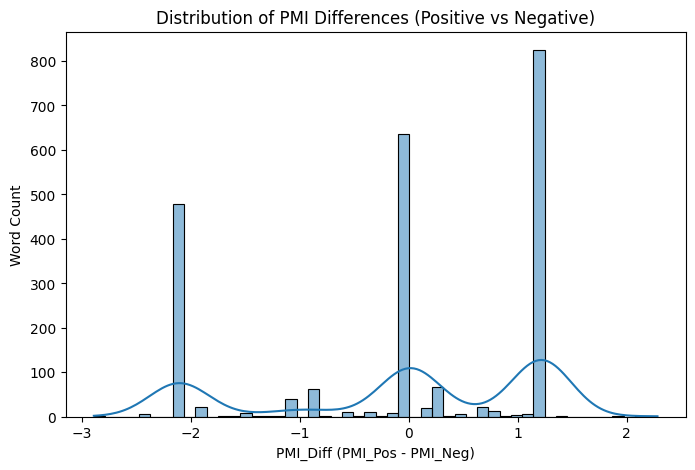


✅ PMI computation complete. Results saved to './outputs/pmi_word_sentiment_scores.csv'


In [7]:
df_lexicon = pd.read_csv('.\corpus_datasets\Zulu_to_English_Corpus.csv')

df_words = []
for idx, row in df_lexicon.iterrows():
    words = row['isiZulu'].lower().split()
    for w in words:
        # Remove punctuation
        w = w.strip('.,!?;"()[]{}')
        # Skip empty strings and stopwords
        if w and w not in zulu_stopwords:
            w = lemmatizer.lemmatize(w)
            df_words.append({'tokens': w, 'label': row['Sentiment'].lower()})

df_tokens_labeled = pd.DataFrame(df_words)

print(f"Total tokens for PMI (after removing stopwords): {len(df_tokens_labeled)}")

# --- Step 1: Frequency of words by sentiment ---

pos_tokens = df_tokens_labeled[df_tokens_labeled['label'] == 'positive']['tokens'].tolist()
neg_tokens = df_tokens_labeled[df_tokens_labeled['label'] == 'negative']['tokens'].tolist()
neu_tokens = df_tokens_labeled[df_tokens_labeled['label'] == 'neutral']['tokens'].tolist() if 'neutral' in df_tokens_labeled['label'].unique() else []

pos_counts = Counter(pos_tokens)
neg_counts = Counter(neg_tokens)
neu_counts = Counter(neu_tokens)
all_counts = Counter(df_tokens_labeled['tokens'])

total_pos = sum(pos_counts.values())
total_neg = sum(neg_counts.values())
total_neu = sum(neu_counts.values()) if neu_tokens else 0
total_all = sum(all_counts.values())

print(f"Total positive words: {total_pos}, negative words: {total_neg}")

# --- Step 2: Compute PMI values ---

pmi_data = []
for word in all_counts:
    p_word = all_counts[word] / total_all
    pmi_pos = math.log2((pos_counts[word] / total_pos) / p_word) if word in pos_counts else 0
    pmi_neg = math.log2((neg_counts[word] / total_neg) / p_word) if word in neg_counts else 0
    pmi_diff = pmi_pos - pmi_neg

    pmi_data.append({
        'word': word,
        'PMI_Pos': pmi_pos,
        'PMI_Neg': pmi_neg,
        'PMI_Diff': pmi_diff,
        'freq_total': all_counts[word],
        'freq_pos': pos_counts[word],
        'freq_neg': neg_counts[word]
    })

df_pmi = pd.DataFrame(pmi_data).sort_values(by='PMI_Diff', ascending=False)

# --- Step 3: Inspect top candidates ---
print("\nTop Positive Words (high PMI_Pos):")
display(df_pmi.nlargest(10, 'PMI_Pos')[['word', 'PMI_Pos', 'freq_total']])

print("\nTop Negative Words (high PMI_Neg):")
display(df_pmi.nlargest(10, 'PMI_Neg')[['word', 'PMI_Neg', 'freq_total']])

# --- Step 4: Visualize word-sentiment association ---
plt.figure(figsize=(8,5))
sns.histplot(df_pmi['PMI_Diff'], bins=50, kde=True)
plt.title("Distribution of PMI Differences (Positive vs Negative)")
plt.xlabel("PMI_Diff (PMI_Pos - PMI_Neg)")
plt.ylabel("Word Count")
plt.show()

# --- Step 5: Save results ---
df_pmi.to_csv("./outputs/pmi_word_sentiment_scores.csv", index=False)
print("\n✅ PMI computation complete. Results saved to './outputs/pmi_word_sentiment_scores.csv'")

In [23]:
# --- TASK F: Statistical Extraction (Enhanced with Co-occurrence) ---
print("\n=== TASK F: Statistical Extraction (Frequency & Co-occurrence Analysis) ===")

from itertools import tee
import os

# Function to generate bigrams
def bigrams(tokens):
    a, b = tee(tokens)
    next(b, None)
    return list(zip(a, b))

# STEP 0: Create token-co-occurrence pairs for each sentence
df_word_pairs = []

for idx, row in df_lexicon.iterrows():
    # Clean, remove stopwords, lemmatize
    words = [lemmatizer.lemmatize(w.strip('.,!?;"()[]{}'))
             for w in row['isiZulu'].lower().split()
             if w and w not in zulu_stopwords]
    
    # Single token entries (co_occur = None)
    for w in words:
        df_word_pairs.append({'tokens': w, 'co_occur': None, 'label': row['Sentiment'].lower()})
    
    # Word-word co-occurrences (bigrams)
    for w1, w2 in bigrams(words):
        df_word_pairs.append({'tokens': w1, 'co_occur': w2, 'label': row['Sentiment'].lower()})

df_co_occurrence = pd.DataFrame(df_word_pairs)

# STEP 1: Frequency of tokens across sentiment labels
co_occurrence = (
    df_co_occurrence
    .groupby(['tokens', 'co_occur', 'label'])
    .size()
    .unstack(fill_value=1)
    .reset_index()
)

# Add total frequency across all labels
labels_present = ['positive','negative','neutral']
for label in labels_present:
    if label not in co_occurrence.columns:
        co_occurrence[label] = 0

co_occurrence['total_freq'] = co_occurrence[['positive','negative','neutral']].sum(axis=1)

# STEP 2: Relative frequency ratios
co_occurrence['pos_ratio'] = co_occurrence['positive'] / co_occurrence['total_freq']
co_occurrence['neg_ratio'] = co_occurrence['negative'] / co_occurrence['total_freq']
co_occurrence['neu_ratio'] = co_occurrence['neutral'] / co_occurrence['total_freq']

# STEP 3: Identify dominant sentiment based on ratio
co_occurrence['dominant_sentiment'] = co_occurrence[['pos_ratio','neg_ratio','neu_ratio']].idxmax(axis=1)
co_occurrence['dominant_sentiment'] = co_occurrence['dominant_sentiment'].str.replace('_ratio','')

# STEP 4: Strength of association (log odds)
co_occurrence['association_strength'] = np.log2(
    (co_occurrence['pos_ratio'] + 1e-6) / (co_occurrence['neg_ratio'] + 1e-6)
)

# STEP 5: Mark strong candidates
threshold_strength = 0.5
strong_candidates = co_occurrence[np.abs(co_occurrence['association_strength']) > threshold_strength]

print(f"\nIdentified {len(strong_candidates)} strong co-occurrence candidates (tokens + co_occur):")
print(strong_candidates.head(10))

# STEP 7: Save enriched results
os.makedirs('./comparison_outputs', exist_ok=True)
strong_candidates.to_csv('./comparison_outputs/pmi_enriched_with_cooccurrence.csv', index=False)

print("\n✅ Task F complete — enriched PMI results saved to './comparison_outputs/pmi_enriched_with_cooccurrence.csv'")


=== TASK F: Statistical Extraction (Frequency & Co-occurrence Analysis) ===

Identified 68 strong co-occurrence candidates (tokens + co_occur):
label              tokens    co_occur  negative  neutral  positive  \
0                                   '         1        2         4   
67                abadala       bethi         2        1         1   
152                abenza  imisebenzi         1        1         2   
368            baqinisile     abadala         2        1         1   
425                  bese     uyinika         1        1         2   
442                 bhala     incwadi         1        1         2   
444                 bhala    inombolo         1        1         4   
468                 chaza    isizathu         1        1         4   
502    ekubhebhethekiseni     udweshu         1        1         2   
506          ekugqamiseni   indikimba         1        1         2   

label  total_freq  pos_ratio  neg_ratio  neu_ratio dominant_sentiment  \
0          

In [11]:
lexicon_dataset_cleaning = pd.read_excel('.\lexicon_dataset\expanded_lexicon_cleaned.xlsx')


#copy original
df_lower = lexicon_dataset_cleaning.copy()

#convert to lowercase
for col in df_lower.columns:
    if df_lower[col].dtype == "object":
        df_lower[col] = df_lower[col].str.lower()


df_lower.head(50)

,Unnamed: 0,CILUBA,French,Score,Sentiment,Nature,English,Zulu,Afrikaans,Sepedi,Xhosa,Shona
0,0,akaja,arrange,0.0,neutral,verbe,arrange,hlela,reël,beakanya,cwangcisa,ronga
1,1,akajilula,rearrange,0.0,neutral,verbe,rearrange,ibanga langemuva,agterreeks,range ya ka morao .,uluhlu lwangasemva,kumashure
2,2,akula,parle,1.0,postive,verbe,speak,khuluma,praat,bolela,thetha,taura
3,3,akulula,reparle,1.0,postive,verbe,speak,khuluma futhi,praat weer,bolela gape .,thetha kwakhona,taura zvakare
4,4,aluja,remet,1.0,postive,verbe,hands,izandla ngaphezulu,hande oor,diatla godimo ga .,izandla ngaphezulu,maoko pamusoro
5,6,ambakaja,supperpose,1.0,postive,verbe,suppose,cabanga,veronderstel,nagana,cinga,ngatitii
6,7,ambula,ramasse,1.0,postive,verbe,pick,phakamisa,tel op,topa,phakamisa,nhonga
7,8,ambuluja,depeche,1.0,postive,verbe,depeche,i-depeche,depeche,depeche .,i-dope,zvinorevache
8,9,ambulula,repete,2.0,postive,verbe,repeated,-phindaphiwe,herhaal,pheta-pheta .,iphindaphindwe,kudzokororwa
9,10,andamuna,repond,2.0,postive,verbe,answers,ukuphendula,antwoorde,dikarabo .,iimpendulo,mhinduro


In [14]:

import re
from copy import deepcopy
from collections import Counter
from rapidfuzz import process, fuzz
from spellchecker import SpellChecker
from tqdm import tqdm

lang_col = {
    "CILUBA": "ciluba",
    "French": "french",
    "English": "english",
    "Zulu": "zulu",
    "Afrikaans": "afrikaans",
    "Sepedi": "sepedi",
    "Xhosa": "xhosa",
    "Shona": "shona",
}

def punc_and_split(s):
    if not isinstance(s, str):
        return []
    raw = s.split()
    tokens = [re.sub(r"^[^\w\-’']+|[^\w\-’']+$", "", t) for t in raw]
    return [t for t in tokens if t]

# count each time a word/token appears in lang
freq = {lang: Counter() for lang in lang_col.values()}
for col, lang in lang_col.items():
    if col in lexicon_dataset_cleaning.columns:
        for val in lexicon_dataset_cleaning[col].dropna().astype(str):
            freq[lang].update(punc_and_split(val))

# select words that appear atleast 2 times to check it
min_freq = 2
vocab = {lang: {tok for tok, c in cnt.items() if c >= min_freq} for lang, cnt in freq.items()}



#english spellchecker
spell_en = SpellChecker(language='en')

def fuzzy_correct(token, lang, score_threshold=90):
    if not vocab[lang]:
        return None, 0
    candidates = process.extract(token, vocab[lang], scorer=fuzz.QRatio, limit=1)
    if candidates:
        best, score, _ = candidates[0]
        if score >= score_threshold:
            return best, score
    return None, 0

def is_all_alpha(token):
    return re.fullmatch(r"[^\W\d_][\w’'\-]*", token, flags=re.UNICODE) is not None

def correct_token(token, lang):
    if not token or not is_all_alpha(token):
        return token, "keep_nonalpha", 100

    if token in vocab[lang]:
        return token, "whitelist_freq", 100

    if lang == "english":
        suggestion = spell_en.correction(token)
        if suggestion and suggestion != token:
            if suggestion in vocab[lang]:
                return suggestion, "en_spell_whitelist", 98
            else:
                return suggestion, "en_spell", 92

    # use fuzzy for other non-english languages to see score
    best, score = fuzzy_correct(token, lang, score_threshold=90)
    if best:
        return best, "fuzzy", score

    # if the confidence is to low it will request manual editing later
    return token, "review", 0

# full dataset run
df_spell = deepcopy(lexicon_dataset_cleaning)
corrections_log = []
review_queue = []

for col, lang in lang_col.items():
    if col not in df_spell.columns:
        continue

    new_vals = []
    col_vals = df_spell[col].astype(str).tolist()

    for val in tqdm(col_vals, desc=f"Spell-checking {col}"):
        tokens = punc_and_split(val)
        new_tokens = []
        for tok in tokens:
            new_tok, method, conf = correct_token(tok, lang)
            new_tokens.append(new_tok)
            if method not in ("whitelist_freq", "keep_nonalpha"):
                corrections_log.append({
                    "column": col, "language": lang,
                    "original": tok, "corrected": new_tok,
                    "method": method, "confidence": conf
                })
                if method == "review":
                    review_queue.append({
                        "column": col, "language": lang,
                        "token": tok, "context": val
                    })
        new_vals.append(" ".join(new_tokens))
    df_spell[col] = new_vals

print(f"Spell check complete. Logged {len(corrections_log)} changes and {len(review_queue)} items to double-check.")

Spell-checking Shona: 100%|██████████| 5312/5312 [00:00<00:00, 30319.88it/s]

Spell check complete. Logged 11155 changes and 10478 items to double-check.


In [16]:
lang_counter = {}
for log in corrections_log:
    lang = log["language"]
    lang_counter[lang] = lang_counter.get(lang, 0) + 1

print("\nAuto-corrections per language:")
for lang, count in lang_counts.items():
    print(f" {lang.capitalize()}: {count}")


Auto-corrections per language:
 Ciluba: 1905
 French: 1974
 English: 1428
 Zulu: 1188
 Afrikaans: 1307
 Sepedi: 1087
 Xhosa: 1159
 Shona: 1107


In [19]:
import string
from copy import deepcopy

#copy of spell checked dataset
df_clean_punc = deepcopy(df_spell)

def remove_punc(text):
    if not isinstance(text, str):
        return text
    #replace punc with empty
    return text.translate(str.maketrans('', '', string.punctuation))

lang_col = [
    "CILUBA", "French", "English", "Zulu",
    "Afrikaans", "Sepedi", "Xhosa", "Shona"
]

for col in lang_col:
    if col in df_clean_punc.columns:
        df_clean_punc[col] = df_clean_punc[col].astype(str).apply(remove_punc)
        #remove double space and strip it
        df_clean_punc[col] = df_clean_punc[col].str.replace(r"\s+", " ", regex=True).str.strip()

print("removed punc")
df_clean_punc.head()

removed punc


,Unnamed: 0,CILUBA,French,Score,Sentiment,Nature,English,Zulu,Afrikaans,Sepedi,Xhosa,Shona
0,0,akaja,arranger,0.0,neutral,verbe,arrange,hlela,reël,beakanya,cwangcisa,ronga
1,1,akajilula,rearrange,0.0,neutral,verbe,rearrange,ibanga langemuva,agterreeks,range ya ka morago,uluhlu lwangasemva,kumashure
2,2,akula,parole,1.0,postive,verbe,speak,khuluma,praat,bolela,thetha,taura
3,3,akulula,reparle,1.0,postive,verbe,speak,khuluma futhi,praat weer,bolela gape,thetha kwakhona,taura zvakare
4,4,aluja,remet,1.0,postive,verbe,hands,izandla ngaphezulu,hande oor,diatla godimo ga,izandla ngaphezulu,maoko pamusoro


In [20]:
import re
from copy import deepcopy

df_clean_space = deepcopy(df_clean_punc)

#keep only text with letters and numbers
def keep_letters_and_numbers(text):
    if not isinstance(text, str):
        return text
    #remove which is not number, letter, single space and also accent marks due to it changing meaning in some african languages
    cleaned = re.sub(r"[^A-Za-z0-9À-ÖØ-öø-ÿ ]+", "", text)
    cleaned = " ".join(cleaned.split())
    return cleaned.strip()

lang_col = [
    "CILUBA", "French", "English", "Zulu",
    "Afrikaans", "Sepedi", "Xhosa", "Shona"
]

for col in lang_col:
    if col in df_clean_space.columns:
        df_clean_space[col] = df_clean_space[col].astype(str).apply(keep_letters_and_numbers)

print(" removed extra spaces, tabs, and non-alphanumeric characters ")
df_clean_space.head()

 removed extra spaces, tabs, and non-alphanumeric characters 


,Unnamed: 0,CILUBA,French,Score,Sentiment,Nature,English,Zulu,Afrikaans,Sepedi,Xhosa,Shona
0,0,akaja,arranger,0.0,neutral,verbe,arrange,hlela,reël,beakanya,cwangcisa,ronga
1,1,akajilula,rearrange,0.0,neutral,verbe,rearrange,ibanga langemuva,agterreeks,range ya ka morago,uluhlu lwangasemva,kumashure
2,2,akula,parole,1.0,postive,verbe,speak,khuluma,praat,bolela,thetha,taura
3,3,akulula,reparle,1.0,postive,verbe,speak,khuluma futhi,praat weer,bolela gape,thetha kwakhona,taura zvakare
4,4,aluja,remet,1.0,postive,verbe,hands,izandla ngaphezulu,hande oor,diatla godimo ga,izandla ngaphezulu,maoko pamusoro


In [21]:
from copy import deepcopy

df_tokens = deepcopy(df_clean_space)

# whitespace token
for col in ["CILUBA", "French", "English", "Zulu", "Afrikaans", "Sepedi", "Xhosa", "Shona"]:
    if col in df_tokens.columns:
        df_tokens[col + "_tokens"] = df_tokens[col].apply(lambda x: x.split() if isinstance(x, str) else [])

print("Whitespace-based tokenization complete")
df_tokens.head()

Whitespace-based tokenization complete


,Unnamed: 0,CILUBA,French,Score,Sentiment,Nature,English,Zulu,Afrikaans,Sepedi,Xhosa,Shona,CILUBA_tokens,French_tokens,English_tokens,Zulu_tokens,Afrikaans_tokens,Sepedi_tokens,Xhosa_tokens,Shona_tokens
0,0,akaja,arranger,0.0,neutral,verbe,arrange,hlela,reël,beakanya,cwangcisa,ronga,[akaja],[arranger],[arrange],[hlela],[reël],[beakanya],[cwangcisa],[ronga]
1,1,akajilula,rearrange,0.0,neutral,verbe,rearrange,ibanga langemuva,agterreeks,range ya ka morago,uluhlu lwangasemva,kumashure,[akajilula],[rearrange],[rearrange],"[ibanga, langemuva]",[agterreeks],"[range, ya, ka, morago]","[uluhlu, lwangasemva]",[kumashure]
2,2,akula,parole,1.0,postive,verbe,speak,khuluma,praat,bolela,thetha,taura,[akula],[parole],[speak],[khuluma],[praat],[bolela],[thetha],[taura]
3,3,akulula,reparle,1.0,postive,verbe,speak,khuluma futhi,praat weer,bolela gape,thetha kwakhona,taura zvakare,[akulula],[reparle],[speak],"[khuluma, futhi]","[praat, weer]","[bolela, gape]","[thetha, kwakhona]","[taura, zvakare]"
4,4,aluja,remet,1.0,postive,verbe,hands,izandla ngaphezulu,hande oor,diatla godimo ga,izandla ngaphezulu,maoko pamusoro,[aluja],[remet],[hands],"[izandla, ngaphezulu]","[hande, oor]","[diatla, godimo, ga]","[izandla, ngaphezulu]","[maoko, pamusoro]"
